# Introduction and Newton-Cotes

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

**Reference**: Chapters 15 and 16 in McClarren (2018). There are two copies in reserve at the library.

In [1]:
# load libraries
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

## Learning Objectives

After studying this notebook, completing the activities, and asking questions in class, you should be able to:
* Draw a sketch to illustrate the main idea behind midpoint, trapezoid and Simpson rules, or identify the rule name from a sketch
* Derive the error order for midpoint and trapezoid rules from a Taylor series expansion
* Approximate a definite integral using Newton-Cotes formulas or quadrature rules in Python

## Motivating Example and Main Idea

Often in engineering, we want or must numerically approximate definite integrals.

### Example: Integrate Normal Distribution

In a few weeks, we will learn how to model random phenomena with probability distributions. Often, standardized test scores follow a normal distribution, a.k.a.,  Gaussian distribution or bell curve.

![sat](https://ndcbe.github.io/data-and-computing/_images/sat.jpg)

These data (which I found online and did not verify... we are just using this as an example) suggest the average SAT score was 1500 with a standard deviation of 250 points. Briefly, mean is the average and standard deviation measures spread. We will mathematically define these quantities in a few class sessions.

Imagine we randomly select a student that took the SAT. What is the probability they received a score of $a = 1800$ points? By assuming the SAT scores are normally distributed, we can express this probability as follows:

$$P(X = a) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}}$$

This is known as the **probability density function** (PDF). $\mu$ is the mean and $\sigma$ is the standard deviation. For our SAT data, $\mu = 1500$ and $\sigma = 250$. $X$ is the outcome of the random experiment, which, for this example, is the SAT score of a randomly selected person. $X$ is capital because it is a random variable. We will formally study all of this in a few notebooks. I am sharing now just to help build comfort.

For convenience, I will use $p(x)$ as shorthand for the PDF:

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}}
$$

Below is a Python function to evaluate the probability density function. Notice I created a lambda function `my_p` with the mean and standard deviation for the SAT example.

In [2]:
def normal_pdf(x,mean,stdev):
    '''Probability density function (PDF) for normal distribution
    Arg:
        x: outcome value
        mean: mean
        stdev: standard deviation
    
    Return: probability    
    '''
    
    assert stdev > 0.0
    
    var = stdev**2
    
    return (1/np.sqrt(2*np.pi*var)) * np.exp(-(x - mean)**2 / 2 / var)

# Integrate numerically. We'll learn the details of how this works later in the class.

my_p = lambda x: normal_pdf(x, mean=1500, stdev=250)

Let's calculate the probability a randomly selected test taker scored 1800. We just need to evaluate $p(1800)$.

In [3]:
my_p(1800)

0.0007767442199328519

0.07% is a very small number! Often, we really want to ask *what is the probability a random test taker scored $a$ or less?* We can write this as a **definite integral**:

$$
P(X \leq a) = \int_{-\infty}^{a} p(x) dx =  \int_{-\infty}^{a} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}} dx
$$

We are integrating the probability density function $p(x)$ from the lowest possible value, $-\infty$, to $a$. *Wait, how do you get a negative SAT score?!?!* This is a great practical point. We'll learn in a few weeks that the normal distribution allows for random variable outcomes between $-\infty$ and $\infty$. But because the probability of really extreme scores is so low, we can still use the normal distribution for many problems, such as the SAT, with valid outcomes over only a finite range, e.g., 0 to 2400.

You decided to trust me on this point, although you are still a little skeptical. So, just substitute $a=1800$, $\mu = 1500$ and $\sigma = 250$ and integrate? The integral looks really hard. I hope it is not on the next exam!

The integral above actually does not have an analytic solution except for some special cases. (You can show analytically that integrating from $-\infty$ and $\infty$ gives 1.) We need to integrate numerically, making it a great motivating example for the next few notebooks on **numeric integration**.

We first replaced the $-\infty$ with $-10000$,

$$
P(X \leq a) \approx \int_{-10000}^{a} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}} dx
$$

and then integrated numerically using ``scipy.integrate.quad``:

In [4]:
value, tol = integrate.quad(my_p,-10000,1800)
print("Integral value = ",value)
print("Integration tolerance (approximate error) = ",tol)

Integral value =  0.8849303297782916
Integration tolerance (approximate error) =  6.5792911954510715e-12


We can see that if we randomly selected an SAT test taker, there is a 88.5% probably they scored 1800 or less. Alternately, if someone scores 1800, we say they are in the 88th percentile. In the rest of this class, we will learn what ``quad`` and other ``scipy`` functions do "under the hood".

### Example: Let's Revisit that Unbounded Assumption

The normal distribution assumes the random variable can have outcomes between $-\infty$ to $\infty$. But, for this year, valid SAT scores were between 0 and 2400. What is the error caused by approximating SAT scores with a normal distribution?

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Using the normal distribution, compute the probability of a score between -10,000 and 0. Store your answer in the Python float <tt>ans_aii1</tt>.
</div>

In [5]:
# Add your solution here

Integral value =  9.865965575048534e-10
Integration tolerance =  1.874391547379387e-09


In [6]:
# Removed autograder test. You may delete this cell.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Using the normal distribution, compute the probability of a score between 2400 and 10,000. Store your answer in the Python float <tt>ans_aii2</tt>.
</div>

In [7]:
# Add your solution here

Integral value =  0.00015910859015752824
Integration tolerance =  9.36189270348194e-10


In [8]:
# Removed autograder test. You may delete this cell.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Write a sentence to defend or refute our choice to model SAT scores with a normal distribution.
</div>

**Home Activity Answer:**

### Main Idea

We will approximate an integral by a sum with a finite number of terms:
$$\int\limits_a^b f(x)\,dx \approx \sum_{l=0}^{L}w_l f(x_l).$$

The function $f( )$ is evaluated at locations (nodes) $x_l$. Each function evaluation is multiplied by weight $w_l$ and then summed.

This approach is known as a **quadrature** rule or simply **numerical integration**. We will focus on two broad families of methods: **Newton-Cotes formulas** and **Gaussian quadrature rules**.

**Connection back to Calculus II**: Writing an integral as a finite sum is analogous to the definition of an integral as a Riemann sum.  Therefore, just as in finite difference derivatives, we use finite mathematics to approximate
the infinitesimals of calculus.

## Newton-Cotes Formulas

This is a broad family of numerical methods that follow the same general recipe:
1. Fit a polynomial through the function evaluations.
2. Integrate the polynomial approximation exactly.

We will not discuss the general theory of Newton-Cotes formulas, but instead focus on three important methods commonly used.

### 1) Midpoint Rule

In the midpoint rule, we approximate the integral by the value of the function in the middle of the range of integration times the length of the region. This simple formula is
$$I_{midpoint} = h\, f\!\left(\frac{a+b}{2}\right) \approx \int\limits_{a}^b f(x)\,dx,$$
where $h = b-a$. We can demonstrate this with a **graphical example**:

$$
f(x) = (x-3) (x-5) (x-7) + 100
$$

Integral estimate =  660.0


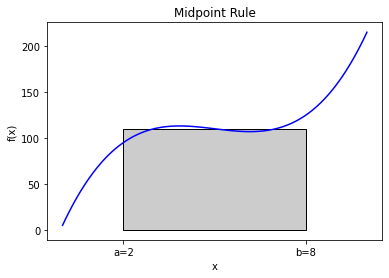

In [9]:
# define and plot function
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# get current axes
ax = plt.gca()

## draw polygon
# define a and b
a = 2
b = 8

# evaluate midpoint
midpoint = 0.5*(a+b)
fmid = f(midpoint)

# estimate integral
Imid = (b-a)*fmid
print("Integral estimate = ",Imid)

# draw rectangle
verts = [(a,0),(a,fmid), (b,fmid),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# add labels
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Midpoint Rule")
plt.show()

The resulting approximation is not terrible, but there are clearly parts of the function where the rectangle does not match the function well. We can do better than a rectangle that approximates the function as flat. 

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the midpoint rule. Save the numeric approximation in the Python variable <tt>ans_bi</tt>. Hint: Use the function <tt>np.sin</tt>.
</div>

Integral estimate =  39.17848549326277


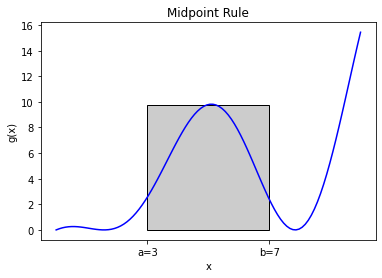

In [10]:
# Add your solution here

In [11]:
# Removed autograder test. You may delete this cell.

### 2) Trapezoid Rule

#### Main Idea and Graphical Example

Instead of approximating with a rectangle (midpoint rule), use a trapezoid:
1. Fit a line between $a$ and $b$. This is a polynomial (linear) approximation to $f(x)$.
2. Integrate the polynomial exactly

The formula for this is
$$ I_\mathrm{trap} \equiv \frac{h}{2}(f(a) + f(b)) \approx \int\limits_a^b f(x)\,dx,$$ where
$h = b - a.$ Here is a graphical example on a polynomial function.

Integral estimate =  660.0


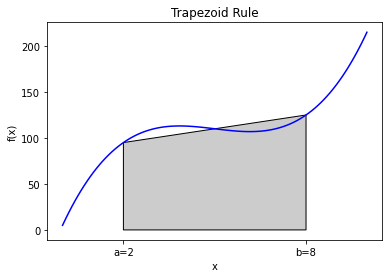

In [12]:
# define and plot function
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# get current axes
ax = plt.gca()

# draw polygon
a = 2
b = 8
verts = [(a,0),(a,f(a)), (b,f(b)),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# estimate integral
Itrap = (b-a)/2*(f(a) + f(b))
print("Integral estimate = ",Itrap)

# add labels
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Trapezoid Rule")
plt.show()

You can see in the figure that the approximation is not exact because the trapezoid does not exactly follow the function, but if $a$ and $b$ are close enough together it should give a good approximation because any well-behaved function can be approximated linearly over a narrow enough domain.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the trapezoid rule. Save the numeric approximation in the Python variable <tt>ans_bii1</tt>.
</div>

Integral estimate =  9.955467569577749


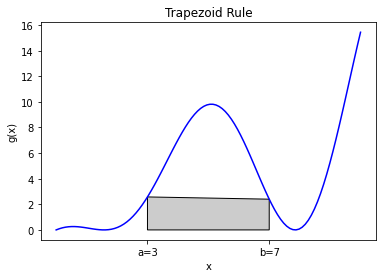

In [13]:
### BEGIN HIDDEN SOLUTION
# define and plot function
g = lambda x: x*(1-np.sin(x))
x = np.linspace(0,10,100)
plt.plot(x,g(x),label="g(x)",color="blue")

# get current axes
ax = plt.gca()

# draw polygon
a = 3
b = 7
verts = [(a,0),(a,g(a)), (b,g(b)),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# estimate integral
Itrap = (b-a)/2*(g(a) + g(b))
print("Integral estimate = ",Itrap)
ans_bii1 = Itrap

# add labels
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Trapezoid Rule")
plt.show()

### END HIDDEN SOLUTION

In [14]:
# Removed autograder test. You may delete this cell.

#### Trapezoid Rule with Multiple Pieces

That leads to a variation to the trapezoid rule (and any other rule for that matter).  We can break up the domain $[a,b]$ into many smaller domains and integrate each of these.  Here's an example where we break $[a,b]$ into 4 pieces:

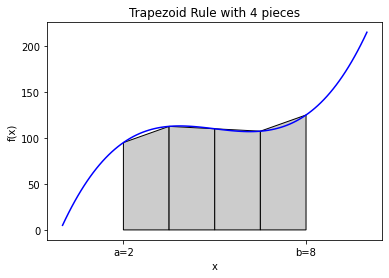

Integral estimate with 4 pieces =  660.0


In [15]:
#graphical example of 4 pieces

# define polynomial and plot
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")
ax = plt.gca()
a = 2
b = 8
h = b - a
N = 4

# draw trapezoids and integrate
Itrap = 0.0
for i in range(N):
    xleft = a+i*h/N
    fleft = f(xleft)
    xright = a+(i+1)*h/N
    fright = f(xright)
    
    Itrap += (h/N/2)*(fleft + fright)
    
    verts = [(xleft,0),(xleft,fleft), (xright,fright),(xright,0)]
    poly = Polygon(verts, facecolor='0.8', edgecolor='k')
    ax.add_patch(poly)
    
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Trapezoid Rule with "+str(N)+" pieces")
plt.show()

print("Integral estimate with",N,"pieces = ",Itrap)

<div class="admonition seealso"> <p class="title"><b>Home Activity</b></p>
 Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the trapezoid rule with $N$ pieces. Per WolframaAlpha, the answer is 27.7314266795455... Determine the minimum number of pieces needed such that approximation, when rounded, matches the exact answer to one decimal place. Store your answer as an integer in <tt>ans_bii2</tt>.
</div>

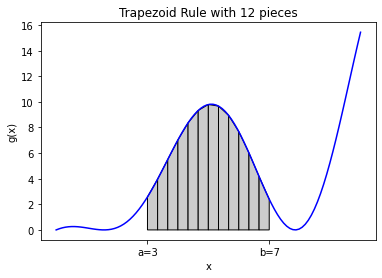

Integral estimate with 12 pieces =  27.650117867008063


In [16]:
# Add your solution here

In [17]:
# Removed autograder test. You may delete this cell.

#### General Purpose Function and Test Case

We can write a trapezoid rule function that will take in a function, $a$, $b$, and the number of pieces and perform this integration. Also, because the right side of each piece is the left side of the next piece, if we're clever we can only evaluate the function once $N+1$ times where $N$ is the number of pieces.

The following function implements the trapezoid rule, and will produce a graph of the approximation when the parameter <tt>graph</tt> is set to true.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Study the code below. Write at least two questions to ask your neighbor during class.
</div>

Question 1:

Question 2:

In [18]:
def trapezoid(f, a, b, pieces, graph=False):
    """Find the integral of the function f between a and b using pieces trapezoids
    Args:
        f: function to integrate
        a: lower bound of integral
        b: upper bound of integral
        pieces: number of pieces to chop [a,b] into
        
    Returns:
        estimate of integral
    """
    # set integral sum to zero
    integral = 0
    
    # calculate total width
    h = b - a
    
    # plot true function
    if (graph):
        x = np.linspace(a,b,100)
        plt.plot(x,f(x),label="f(x)",color="blue")
        ax = plt.gca()
    
    # initialize the left function evaluation
    fa = f(a)
    
    for i in range(pieces):
        # evaluate the function at the right end of the current piece
        fb = f(a + (i+1)*h/pieces)
        
        # add to integral
        integral += 0.5*h/pieces*(fa + fb)
        
        # plot the current piece
        if (graph):
            verts = [(a+i*h/pieces,0),(a+i*h/pieces,fa), (a+(i+1)*h/pieces,fb),(a+(i+1)*h/pieces,0)]
            poly = Polygon(verts, facecolor='0.9', edgecolor='k')
            ax.add_patch(poly)
            
        # now make the left function evaluation the right for the next step
        fa = fb
    
    # label plot
    if (graph):
        ax.set_xticks((a,b))
        ax.set_xticklabels(('a='+str(a),'b='+str(b)))
        plt.xlabel("x")
        plt.ylabel("f(x)")
        if (pieces > 1):
            plt.title("Trapezoid Rule with " + str(pieces) + " pieces")
        else:
            plt.title("Trapezoid Rule with " + str(pieces) + " piece")
        plt.show()
    return integral

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Run the code below.

Let's test this method on a function that we know the integral of $$\int\limits_0^\pi \sin x\,dx = 2.$$

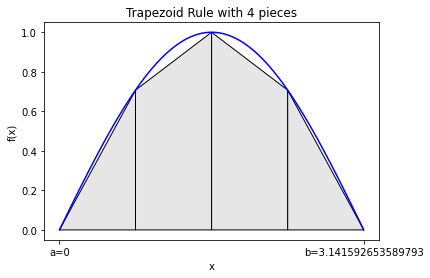

Estimate is 1.8961188979370398 while the actual value is 2


In [19]:
integral_estimate = trapezoid(np.sin,0,np.pi,pieces=4,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

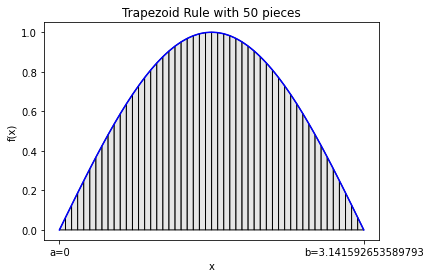

Estimate is 1.999341983076262 while the actual value is 2


In [20]:
integral_estimate = trapezoid(np.sin,0,np.pi,pieces=50,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

#### Error Analysis

How does the error change as we increase the number pieces (i.e., decrease the step size $h$)?

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Run the code below.

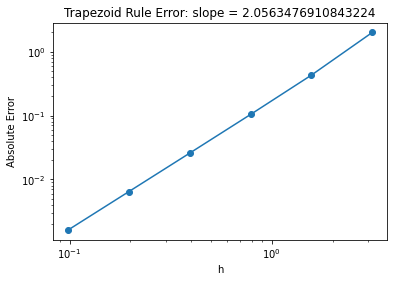

In [21]:
pieces = 2**np.arange(0,6)
error = np.zeros(6)
count = 0
for p in pieces:
    error[count] = np.fabs(trapezoid(np.sin,0,np.pi,pieces=p,graph=False) - 2.0)
    count += 1
h = np.pi/pieces
plt.loglog(h,error,'o-')
slope = (np.log(error[0]) - np.log(error[-1]))/(np.log(h[0]) - np.log(h[-1]) )
plt.title("Trapezoid Rule Error: slope = " + str(slope))
plt.xlabel("h")
plt.ylabel("Absolute Error")
plt.show()

Similar to what we did for finite difference derivatives, we can plot the error versus number of pieces on a log-log scale. The error in the trapezoid rule that we observe is second-order in $h$, because the slope of the error on the log-log scale is 2.

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Go through the derivation below on the chalkboard.
</div>

**We will now use a Taylor series to show why the slope is 2.**

We can see that this is the expected error in the estimate by looking at the linear approximation to a function around $x = a$:
$$f(x) = f(a) + (x-a) f'(a) + \frac{(x-a)^2}{2} f''(a) + O((x-a)^3).$$
We can approximate the derivative using a forward difference:
$$f'(a) \approx \frac{f(b) - f(a)}{h} + O(h),$$
where $h = b-a$. Now the integral of $f(x)$ from $a$ to $b$ becomes
$$\int \limits_a^b f(x)\,dx = h f(a) + \int\limits_a^b (x-a) f'(a)\,dx +\int\limits_a^b \frac{(x-a)^2}{2} f''(a)\,dx + O(h^4).$$
The integral $$\int\limits_a^b (x-a) f'(a) dx = \frac{(b-a)^2}{2}f'(a) = \frac{h^2}{2}\left(\frac{f(b) - f(a)}{h} + O(h)\right)
= \frac{h}{2}\left(f(b)-f(a)\right) + O(h^3).$$
Additionally,
$$\int\limits_a^b \frac{(x-a)^2}{2} f''(a)\,dx = -\frac{h^3}{6} f''(a) = O(h^3).$$
When we plug this into the original integral we get
$$\int \limits_a^b f(x)\,dx = \frac{h}{2} (f(a) + f(b)) + O(h^3).$$
This says that error in one piece of the trapezoid rule is third-order accurate, which means the error can be written as $C h^3 + O(h^4)$.  However, when we break the interval into $N$ pieces, each of size $h = (b-a)/N$, the error terms add and each piece has its own constant so that
$$\sum_{i=1}^N C_i h^3 \leq N h^3 C_\mathrm{max} = (b-a)C_\mathrm{max} h^2,$$
where $C_\mathrm{max}$ is the maximum value of $|C_i|$.  Therefore, the error in the sum of trapezoid rules decreases as $h^2$, which we observed above.  This analysis can be extended to show that the error terms in the trapezoid rule only have even powers of $h$: $$\mathrm{Error} = C_2 h^2 + C_4 h^4 + \dots$$

### Simpson's Rule

We will now take the idea of the trapezoid rule a step further by **fitting a parabola** between three points: $a$, $b$, and $(a+b)/2$.  The formula for this is
$$ I_\mathrm{Simpson} \equiv \frac{h}{6}\left(f(a) + 4 f\left(a + \frac{h}{2}\right) + f(b)\right) \approx \int\limits_a^b f(x)\,dx,$$ where
$h = b - a.$

Footnote: This is sometimes called Simpsions 1/3 rule.

#### Quadratic Interpolation

Before examining Simpson's rule, we need to quickly discuss quadratic interpolation. Let's say I have evaluated the function $g(x)$ at three points: $a_1$, $a_2$ and $a_3$. I now want to approximate $g(x)$ and any point $x$ using **quadratic interpolation**.

$$
g(x) \approx \frac{(x-a_2)(x-a_3)}{(a_1 - a_2)(a_1 - a_3)} g(a_1) + \frac{(x-a_1)(x-a_3)}{(a_2 - a_1)(a_2 - a_3)} g(a_2) + \frac{(x-a_1)(x-a_2)}{(a_3 - a_1)(a_3 - a_2)} g(a_3)
$$

In [22]:
def quadratic_interp(a,f,x):
    """Compute at quadratic interpolant
    Args:
        a: array of the 3 points
        f: array of the value of f(a) at the 3 points
        x: point to interpolate at
    Returns:
        The value of the linear interpolant at x
    """
    answer = (x-a[1])*(x-a[2])/(a[0]-a[1])/(a[0]-a[2])*f[0] 
    answer += (x-a[0])*(x-a[2])/(a[1]-a[0])/(a[1]-a[2])*f[1] 
    answer += (x-a[0])*(x-a[1])/(a[2]-a[0])/(a[2]-a[1])*f[2] 
    return answer

Let's return to the example $f(x) = (x-3)(x-5)(x-7)+110$ to test our function.

In [23]:
f = lambda x: (x-3)*(x-5)*(x-7)+110

Now let's test our quadratic interpolation formula. We'll choose $x=0$, $x=1$, and $x=2$ as the three node locations. We'll start by evaluating our function $f(x)$ at these three points.

In [24]:
x_nodes = np.array([0.0, 1.0, 2.0])
f_nodes = np.zeros(len(x_nodes))

# loop over elements of x_node
for i in range(len(x_nodes)):
    # evaluate f() and store answer in f_nodes
    f_nodes[i] = f(x_nodes[i])
    # print to screen
    print("f(",x_nodes[i],") =",f_nodes[i])

f( 0.0 ) = 5.0
f( 1.0 ) = 62.0
f( 2.0 ) = 95.0


Now let's evaluate our interpolation function $g(x)$ at these three points:

In [25]:
quadratic_interp(x_nodes, f_nodes, 0.25)

21.5

In [26]:
for i in x_nodes:
    print("g(",i,") =",quadratic_interp(x_nodes, f_nodes, i))

g( 0.0 ) = 5.0
g( 1.0 ) = 62.0
g( 2.0 ) = 95.0


We see the quadratice interpolation $g(x)$ is exact at the three nodes. Please verify this makes sense based on the formula for $g(x)$.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Evaluate the original function $f(x)$ and the quadratic interpolation approximation $g(x)$ at $x=0.25$. Record your answer in <tt>f_b_iii</tt> and <tt>g_b_iii</tt>. Use the same nodes as the example, i.e., do not modify <tt>x_nodes</tt> and <tt>f_nodes</tt>.
</div>

In [27]:
# Add your solution here

f( 0.25 ) = 21.828125
g( 0.25 ) = 21.5


In [28]:
# Removed autograder test. You may delete this cell.

You should see the quadratic interpolant is a good approximation, but not perfect.

The code below graphically explores $g(x)$.

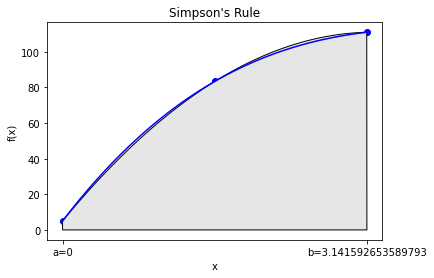

In [29]:
# plot true function in blue
a = 0
b = np.pi
x = np.linspace(a,b,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# assemble nodes of three points, plot as circles
nodes = [a,0.5*(a+b),b]
fnodes = f(np.array([a,0.5*(a+b),b]))
plt.scatter(nodes, fnodes, marker='o',color='blue')

# plot polygon to visualize quadratic interpolation
ax = plt.gca()
ix = np.arange(a, b, 0.01)
iy = quadratic_interp(nodes,fnodes,ix)
verts = [(a,0)] + list(zip(ix,iy)) + [(b,0)]
poly = plt.Polygon(verts, facecolor='0.9', edgecolor='k')
ax.add_patch(poly)

# label axes
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Simpson's Rule")
plt.show()

We can see the quadratic function fits $f(x)$ really well. This is not that surprising, as $f(x)$ is a cubic.

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Copy the code above to below. Adapt the copied code to explore $g(x) = x (1-\sin(x))$. Write a sentence to discuss the results.
</div>

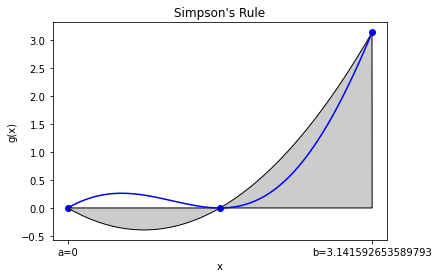

In [30]:
# Add your solution here

**Home Activity Discussion:**

#### General Purpose Function and Test Case

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Study the code below. Write at least two questions to ask your neighbor during class.
</div>

In [31]:
def simpsons(f, a, b, pieces, graph=False):
    """Find the integral of the function f between a and b using Simpson's rule
    Args:
        f: function to integrate
        a: lower bound of integral
        b: upper bound of integral
        pieces: number of pieces to chop [a,b] into
        
    Returns:
        estimate of integral
    """
    
    # set integral counter to 0
    integral = 0
    
    # calculate total witdth
    h = b - a
    
    # compute and save 1/6
    one_sixth = 1.0/6.0
    
    # plot function
    if (graph):
        x = np.linspace(a,b,100)
        plt.plot(x,f(x),label="f(x)",color="blue")
        ax = plt.gca()
    
    #initialize the left function evaluation
    fa = f(a)
    for i in range(pieces):
        # evaluate the function at the right end of the piece
        fb = f(a + (i+1)*h/pieces)
        fmid = f(a + (i+0.5)*h/pieces)
        integral += one_sixth*h/pieces*(fa + 4*fmid + fb)
        
        # visualize piece
        if (graph):
            ix = np.arange(a+i*h/pieces, a+(i+1)*h/pieces, 0.001)
            iy = quadratic_interp(np.array([a+i*h/pieces,0.5*(a+(i+1)*h/pieces+ a+i*h/pieces),a+(i+1)*h/pieces]),
                                  np.array([fa,fmid,fb]),ix)
            verts = [(a+i*h/pieces,0)] + list(zip(ix,iy)) + [(a+(i+1)*h/pieces,0)]
            poly = plt.Polygon(verts, facecolor='0.9', edgecolor='k')
            ax.add_patch(poly)
        
        # now make the left function evaluation the right for the next step
        fa = fb
        
    # label plot    
    if (graph):
        ax.set_xticks((a,b))
        ax.set_xticklabels(('a='+str(a),'b='+str(b)))
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title("Simpsons Rule with " + str(pieces) + " pieces")
        plt.show()
    return integral

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Complete the activity on the handout.
</div>

We wrote a function. Now let's test it by approximating:

$$
\int_{0}^{\pi} \sin(x) dx
$$

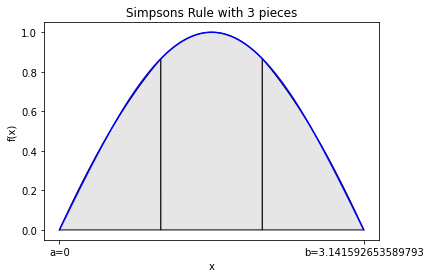

Estimate is 2.000863189673536 while the actual value is 2


In [32]:
integral_estimate = simpsons(np.sin,0,np.pi,pieces=3,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Recompute the integral estimate with 50 pieces. Store the answer in <tt>ans_biii_50</tt>.
</div>

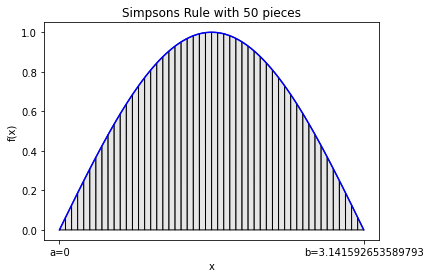

Estimate is 2.0000000108245035 Actual value is 2


In [33]:
### BEGIN SOLUTION
integral_estimate = simpsons(np.sin,0,np.pi,pieces=50,graph=True)
print("Estimate is",integral_estimate,"Actual value is 2")
ans_biii_50 = integral_estimate
### END SOLTUON

In [34]:
# Removed autograder test. You may delete this cell.

#### Error Analysis

<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 Run the code below.
</div>

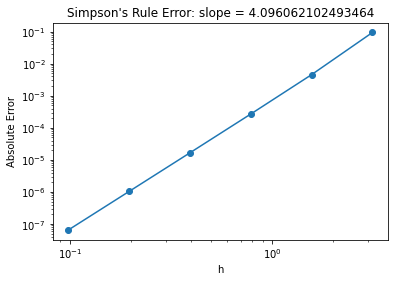

In [35]:
pieces = 2**np.arange(0,6)
error = np.zeros(6)
count = 0
for p in pieces:
    error[count] = np.fabs(simpsons(np.sin,0,np.pi,pieces=p,graph=False) - 2.0)
    count += 1
h = np.pi/pieces
plt.loglog(h,error,'o-')
slope = (np.log(error[0]) - np.log(error[-1]))/(np.log(h[0]) - np.log(h[-1]) )
plt.title("Simpson's Rule Error: slope = " + str(slope))
plt.xlabel("h")
plt.ylabel("Absolute Error")
plt.show()

Simpson's rule is fourth-order in the piece size. This means that every time I double the number of pieces the error goes down by a factor of $2^4 = 16$. 

#### Another Example: Approximating $\pi$

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Run code below and discuss.
</div>


We can approximate $\pi$ with the following integral:

$$ \int\limits_0^1 4 \sqrt{1-x^2}\,dx = \pi$$

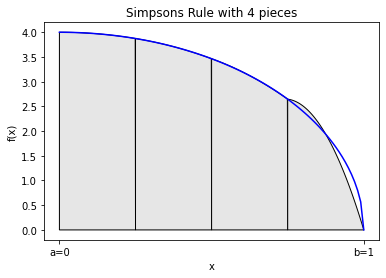

3.1211891697754175

In [36]:
integrand = lambda x: 4*np.sqrt(1-x**2)
simpsons(integrand,0,1,pieces = 4,graph=True) #actual value is 3.14159

Most of the error comes at $x=1$. This is because the derivative of $\sqrt{1-x^2}$ is singular at $x=1$, which makes it difficult to build an accurate polynomial approximation.